In [46]:
import pandas as pd
from datetime import datetime

In [47]:
df_24 = pd.read_csv('fc24_dataframe.csv')

df_24 = df_24.sort_values(['card_id', 'date']).reset_index(drop=True)

df_24 = df_24.drop('name', axis=1)
df_24 = df_24.drop('acceleration', axis=1)
df_24 = df_24.drop('sprint_speed', axis=1)
df_24 = df_24.drop('att_position', axis=1)
df_24 = df_24.drop('finishing', axis=1)
df_24 = df_24.drop('shot_power', axis=1)
df_24 = df_24.drop('long_shots', axis=1)
df_24 = df_24.drop('volleys', axis=1)
df_24 = df_24.drop('penalties', axis=1)
df_24 = df_24.drop('vision', axis=1)
df_24 = df_24.drop('crossing', axis=1)
df_24 = df_24.drop('fk_accuracy', axis=1)
df_24 = df_24.drop('short_pass', axis=1)
df_24 = df_24.drop('long_pass', axis=1)
df_24 = df_24.drop('curve', axis=1)
df_24 = df_24.drop('agility', axis=1)
df_24 = df_24.drop('balance', axis=1)
df_24 = df_24.drop('reactions', axis=1)
df_24 = df_24.drop('ball_control', axis=1)
df_24 = df_24.drop('dribbling', axis=1)
df_24 = df_24.drop('composure', axis=1)
df_24 = df_24.drop('interceptions', axis=1)
df_24 = df_24.drop('heading_acc', axis=1)
df_24 = df_24.drop('def_aware', axis=1)
df_24 = df_24.drop('stand_tackle', axis=1)
df_24 = df_24.drop('slide_tackle', axis=1)
df_24 = df_24.drop('jumping', axis=1)
df_24 = df_24.drop('stamina', axis=1)
df_24 = df_24.drop('strength', axis=1)
df_24 = df_24.drop('aggression', axis=1)
df_24 = df_24.drop('body_type', axis=1)
df_24 = df_24.drop('accelerate', axis=1)
df_24 = df_24.drop('card_page_url', axis=1)
df_24 = df_24.drop('positions', axis=1)
df_24 = df_24.drop('playstyles', axis=1)
df_24 = df_24.drop('weight', axis=1)

# Ensure 'date' column is in datetime format
df_24['date'] = pd.to_datetime(df_24['date'])

In [15]:
df_24.columns

Index(['card_id', 'rating', 'skill_moves', 'weak_foot', 'pace_m', 'shooting_m',
       'passing_m', 'dribbling_m', 'defending_m', 'physical_m', 'height',
       'total_ingame_stats', 'nation', 'league', 'club', 'intl_rep', 'date',
       'price', 'days_since_start', 'days_until_end', 'days_since_release',
       'price_t_plus_7'],
      dtype='object')

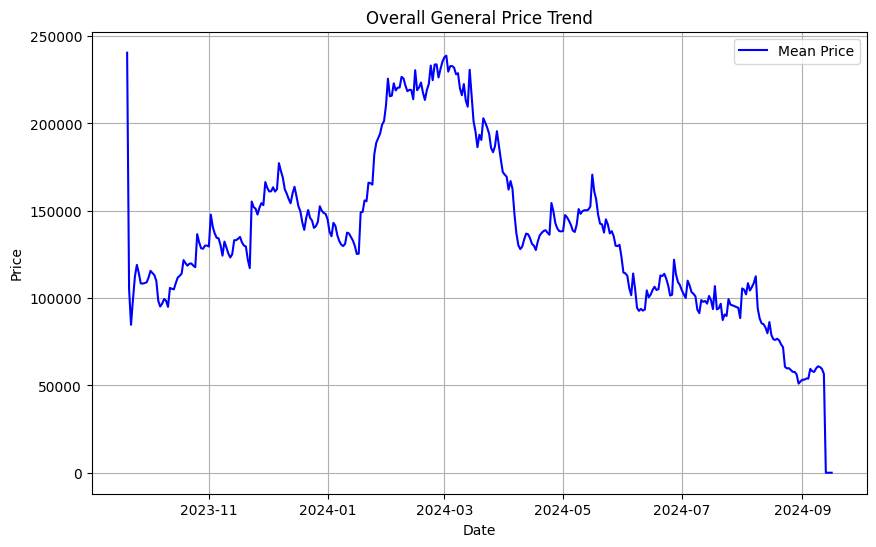

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate prices by date
aggregated = df_24.groupby('date')['price'].mean().reset_index()

# Plot the general trend
plt.figure(figsize=(10, 6))
plt.plot(aggregated['date'], aggregated['price'], label='Mean Price', color='blue')
plt.title('Overall General Price Trend')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [ ]:
df_24.isnull().sum()

In [48]:
# Get start and end dates of the game cycle
fc24_start_date = df_24['date'].min()
fc24_end_date = df_24['date'].max()

# Compute days_since_start and days_until_end based on FC24 game cycle
df_24['days_since_start'] = (df_24['date'] - fc24_start_date).dt.days
df_24['days_until_end'] = (fc24_end_date - df_24['date']).dt.days

# Get the first release date (earliest date) for each card_id
card_release_dates = df_24.groupby('card_id')['date'].min().rename('release_date')

# Merge release dates back into the DataFrame
df_24 = df_24.merge(card_release_dates, on='card_id', how='left')

# Compute days_since_release for each card
df_24['days_since_release'] = (df_24['date'] - df_24['release_date']).dt.days

# Drop the 'release_date' column if it's no longer needed
df_24 = df_24.drop(columns=['release_date'])

# Remove rows with price = 0
df_24 = df_24[df_24['price'] > 0].reset_index(drop=True)

# Step 1: Calculate price at t+7 for each card_id
df_24['price_t_plus_7'] = df_24.groupby('card_id')['price'].shift(-7)

# Step 2: Compute percentage change between t and t+7
df_24['price_pct_change'] = (df_24['price_t_plus_7'] - df_24['price']) / df_24['price']

# Step 3: Drop rows where t+7 price is NaN (cannot calculate percentage change)
df_24 = df_24.dropna(subset=['price_pct_change']).reset_index(drop=True)

# Step 4: Drop intermediate column if no longer needed
df_24 = df_24.drop(columns=['price_t_plus_7'])

# Check the remaining rows
print(f"Number of rows after removing 0 price: {len(df_24)}")

# Step 2: Sort and Prepare Data
df_24['date'] = pd.to_datetime(df_24['date'])  # Ensure date is datetime
df_24 = df_24.sort_values(['card_id', 'date']).reset_index(drop=True)  # Sort by card_id and date

df_24['height'] = df_24['height'].fillna(df_24['height'].median())
df_24['nation'] = df_24['nation'].fillna('Unknown')
df_24['league'] = df_24['league'].fillna('Unknown')
df_24['club'] = df_24['club'].fillna('Unknown')
df_24['intl_rep'] = df_24['intl_rep'].fillna(1)

Number of rows after removing 0 price: 1046517


In [49]:
# Calculating the lowest percent change and the occurrences above the positive of the lowest value
lowest_pct_change = df_24['price_pct_change'].min()
occurrences_above_threshold = df_24[df_24['price_pct_change'] > -lowest_pct_change].shape[0]

lowest_pct_change, occurrences_above_threshold

(-0.9852913865468187, 13131)

In [50]:
# Keep rows where price_pct_change is between -1 and 1 (inclusive)
df_24 = df_24[(df_24['price_pct_change'] >= -1) & (df_24['price_pct_change'] <= 1)].reset_index(drop=True)

# Check the new size of the dataset
print(f"Number of rows after filtering: {len(df_24)}")


Number of rows after filtering: 1033694


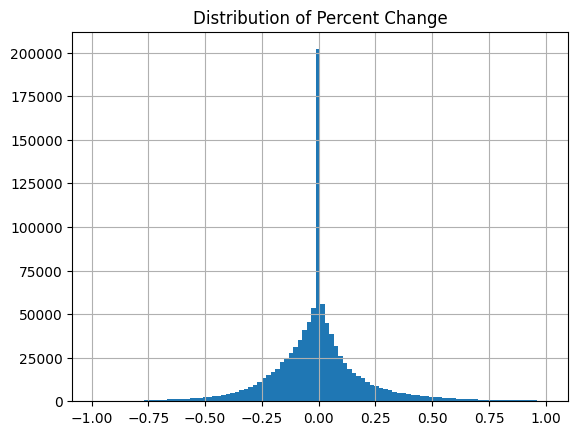

In [51]:
import matplotlib.pyplot as plt
df_24['price_pct_change'].hist(bins=100)
plt.title('Distribution of Percent Change')
plt.show()

In [52]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders
le_nation = LabelEncoder()
le_league = LabelEncoder()
le_club = LabelEncoder()

# Apply label encoding to each categorical column
df_24['nation'] = le_nation.fit_transform(df_24['nation'].astype(str))
df_24['league'] = le_league.fit_transform(df_24['league'].astype(str))
df_24['club'] = le_club.fit_transform(df_24['club'].astype(str))

# Verify encoding
print("Unique values in 'nation':", len(le_nation.classes_))
print("Unique values in 'league':", len(le_league.classes_))
print("Unique values in 'club':", len(le_club.classes_))

Unique values in 'nation': 99
Unique values in 'league': 45
Unique values in 'club': 263


In [53]:
import numpy as np
import pandas as pd

# Step 1: Remove the price_pct_change column
df_24 = df_24.drop(columns=['price_pct_change'])

# Step 2: Create the price_t_plus_7 column
df_24['price_t_plus_7'] = (
    df_24.groupby('card_id')['price'].shift(-7)
)

# Drop rows where `price_t_plus_7` is NaN (since those are incomplete sequences)
df_24 = df_24.dropna(subset=['price_t_plus_7']).reset_index(drop=True)

In [54]:
from sklearn.model_selection import train_test_split

# Get the unique card_ids
unique_card_ids = df_24['card_id'].unique()

# Split card_ids into train, val, and test
train_card_ids, temp_card_ids = train_test_split(unique_card_ids, test_size=0.3, random_state=42)
val_card_ids, test_card_ids = train_test_split(temp_card_ids, test_size=0.5, random_state=42)

# Print counts for each split
print(f"Training card_ids: {len(train_card_ids)}")
print(f"Validation card_ids: {len(val_card_ids)}")
print(f"Test card_ids: {len(test_card_ids)}")

Training card_ids: 2300
Validation card_ids: 493
Test card_ids: 494


In [55]:
import numpy as np

# Define look-back
look_back = 7

# Function to create time-series sequences
def create_sequences(data, card_ids, look_back, input_cols, target_col):
    X, y, card_ids_seq = [], [], []
    for card_id in card_ids:
        group = data[data['card_id'] == card_id].sort_values('date')  # Filter and sort by date
        features = group[input_cols].values
        target = group[target_col].values

        # Sliding window logic
        for i in range(len(features) - look_back):
            X.append(features[i:i + look_back])  # Look-back window
            y.append(target[i + look_back])  # Target on the 7th day
            card_ids_seq.append(card_id)  # Track card_id for the sequence

    return np.array(X), np.array(y), np.array(card_ids_seq)

# Define input and target columns
input_cols = [col for col in df_24.columns if col not in ['card_id', 'date', 'price_t_plus_7']]
target_col = 'price_t_plus_7'

# Create sequences for each split
X_train, y_train, card_ids_train = create_sequences(df_24, train_card_ids, look_back, input_cols, target_col)
X_val, y_val, card_ids_val = create_sequences(df_24, val_card_ids, look_back, input_cols, target_col)
X_test, y_test, card_ids_test = create_sequences(df_24, test_card_ids, look_back, input_cols, target_col)

# Print shapes for verification
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (692397, 7, 19), (692397,)
Validation set shape: (140266, 7, 19), (140266,)
Test set shape: (155021, 7, 19), (155021,)


In [56]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler()

# Flatten training set for scaling
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)

# Scale validation and test sets
X_val_flat = X_val.reshape(-1, X_val.shape[-1])
X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)

X_test_flat = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

# Print shapes for scaled data
print(f"Scaled X_train shape: {X_train_scaled.shape}")
print(f"Scaled X_val shape: {X_val_scaled.shape}")
print(f"Scaled X_test shape: {X_test_scaled.shape}")

Scaled X_train shape: (692397, 7, 19)
Scaled X_val shape: (140266, 7, 19)
Scaled X_test shape: (155021, 7, 19)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# DNN Model
def build_dnn(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),  # Flatten the sequence data
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Single output for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Build the DNN model
dnn_model = build_dnn(X_train_scaled.shape[1:])

2025-01-02 16:01:48.252926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/vinayaksankaranarayanan/Desktop/FUT_Project/.venv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# Train the DNN model
dnn_history = dnn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=20,
    batch_size=64,
    verbose=1
)

# Evaluate on the test set
dnn_test_loss, dnn_test_mae = dnn_model.evaluate(X_test_scaled, y_test)
print(f"DNN Test Loss: {dnn_test_loss}, Test MAE: {dnn_test_mae}")

Epoch 1/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 320779714560.0000 - mae: 167803.6406 - val_loss: 156607610880.0000 - val_mae: 120288.8438
Epoch 2/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 172400656384.0000 - mae: 121999.0391 - val_loss: 66659979264.0000 - val_mae: 83575.0156
Epoch 3/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 63327977472.0000 - mae: 80895.1562 - val_loss: 29260890112.0000 - val_mae: 62756.0898
Epoch 4/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 32821223424.0000 - mae: 61424.4766 - val_loss: 18372655104.0000 - val_mae: 51027.3438
Epoch 5/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 25487677440.0000 - mae: 51555.3945 - val_loss: 13665774592.0000 - val_mae: 44248.2305
Epoch 6/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - loss: 22032910336.0000 - mae: 46482.5156 - val_loss: 11845903360.0000 - val_mae: 39788.5664
Epoch 7/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - loss: 20346996736.0000 - mae:

4845/4845 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


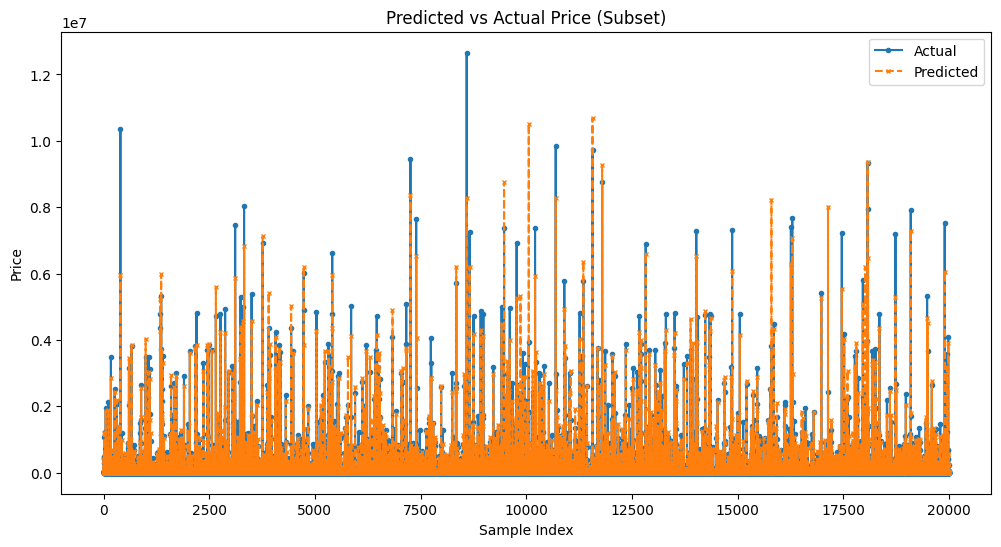

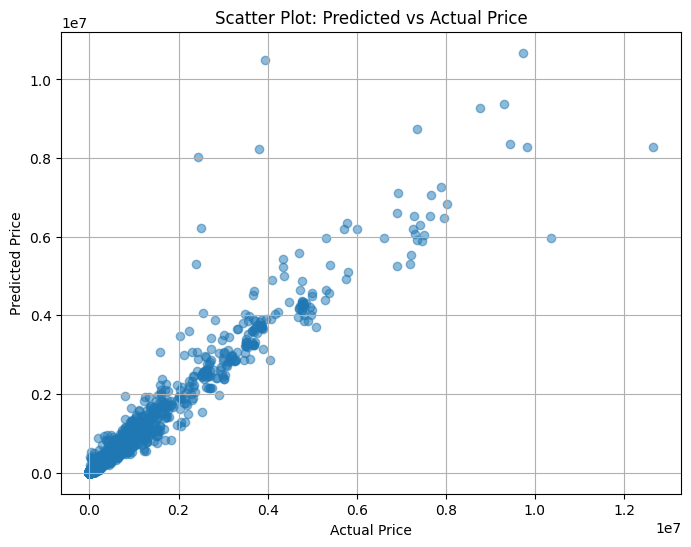

In [26]:
# Assuming the trained model is named model_dnn
y_pred = dnn_model.predict(X_test_scaled)

# Now let's re-run the subset visualization:
import numpy as np
import matplotlib.pyplot as plt

# Select a random subset for better visualization
subset_indices = np.random.choice(len(y_test), size=20000, replace=False)
subset_actual = y_test[subset_indices]
subset_predicted = y_pred[subset_indices]

# Plot: Zoomed-in line plot for a subset
plt.figure(figsize=(12, 6))
plt.plot(subset_actual, label='Actual', marker='o', linestyle='-', markersize=3)
plt.plot(subset_predicted, label='Predicted', marker='x', linestyle='--', markersize=3)
plt.title('Predicted vs Actual Price (Subset)')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot: Scatter plot for predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(subset_actual, subset_predicted, alpha=0.5)
plt.title("Scatter Plot: Predicted vs Actual Price")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True)
plt.show()

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Define the CNN model
model_cnn = Sequential([
    Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    Conv1D(filters=32, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Predicting a single price value
])

# Compile the model
model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model Summary
print(model_cnn.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 6, 64)          │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,553 (138.88 KB)

 Trainable params: 35,553 (138.88 KB)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
# Train the model
history_cnn = model_cnn.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=20,  # Starting with 20 epochs
    batch_size=128,
    verbose=1
)

# Evaluate the model
cnn_eval = model_cnn.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test Loss: {cnn_eval[0]}, Test MAE: {cnn_eval[1]}")

Epoch 1/20
5410/5410 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 164928978944.0000 - mae: 107355.8359 - val_loss: 15170029568.0000 - val_mae: 45451.4727
Epoch 2/20
5410/5410 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 22223675392.0000 - mae: 45256.2344 - val_loss: 13406424064.0000 - val_mae: 38807.6758
Epoch 3/20
5410/5410 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 20443922432.0000 - mae: 40688.3945 - val_loss: 11462968320.0000 - val_mae: 42029.6094
Epoch 4/20
5410/5410 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 18441162752.0000 - mae: 38061.3672 - val_loss: 9517592576.0000 - val_mae: 31382.1406
Epoch 5/20
5410/5410 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 19238400000.0000 - mae: 37181.8516 - val_loss: 9053782016.0000 - val_mae: 31214.1621
Epoch 6/20
5410/5410 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 16966022144.0000 - mae: 34805.2148 - val_loss: 8037379584.0000 - val_mae: 28990.5918
Epoch 7/20
5410/5410 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 15888841728.0000 - mae: 34005.2500 - val_los

In [29]:
# Make Predictions
y_pred_cnn = model_cnn.predict(X_test_scaled)

4845/4845 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


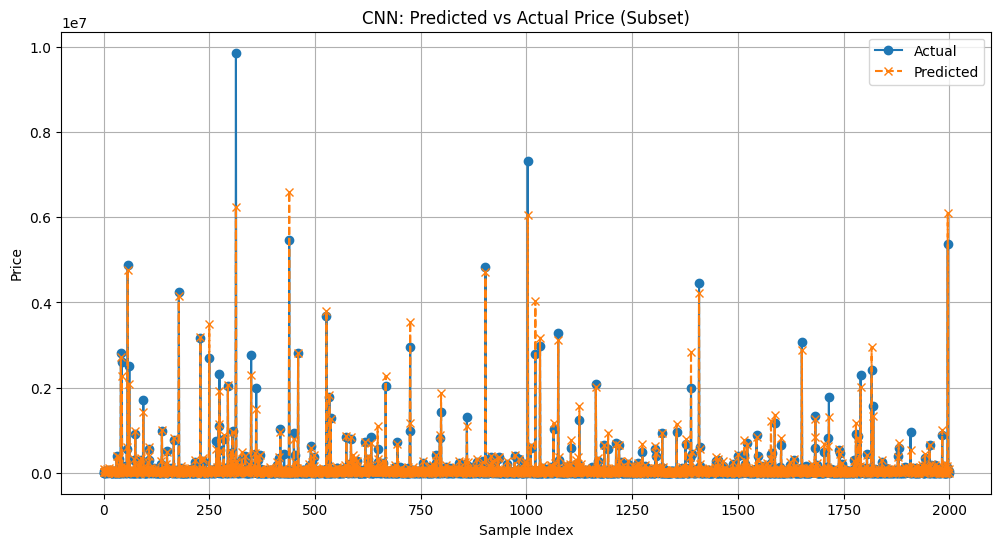

In [31]:
# Visualization
import matplotlib.pyplot as plt
subset_indices = np.random.choice(len(y_test), size=2000, replace=False)
subset_actual = y_test[subset_indices]
subset_predicted = y_pred_cnn[subset_indices]

plt.figure(figsize=(12, 6))
plt.plot(subset_actual, label='Actual', marker='o', linestyle='-')
plt.plot(subset_predicted, label='Predicted', marker='x', linestyle='--')
plt.title('CNN: Predicted vs Actual Price (Subset)')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Single output for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create the model
model_lstm = create_lstm_model()

# Summary of the model
model_lstm.summary()

/Users/vinayaksankaranarayanan/Desktop/FUT_Project/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 128)         │        75,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,297 (497.25 KB)

 Trainable params: 127,297 (497.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 140s 13ms/step - loss: 80086147072.0000 - mae: 77958.1250 - val_loss: 36722491392.0000 - val_mae: 60204.4961
Epoch 2/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 133s 12ms/step - loss: 37162717184.0000 - mae: 56404.7617 - val_loss: 21445400576.0000 - val_mae: 46623.8281
Epoch 3/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 132s 12ms/step - loss: 28678326272.0000 - mae: 48580.0977 - val_loss: 25597241344.0000 - val_mae: 38754.7461
Epoch 4/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 151s 14ms/step - loss: 29491146752.0000 - mae: 47344.4102 - val_loss: 16048605184.0000 - val_mae: 50226.2695
Epoch 5/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 149s 14ms/step - loss: 30023956480.0000 - mae: 50529.1875 - val_loss: 12670924800.0000 - val_mae: 36157.3398
Epoch 6/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 150s 14ms/step - loss: 27017826304.0000 - mae: 46128.0586 - val_loss: 12252831744.0000 - val_mae: 38540.5508
Epoch 7/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 153s 14ms/step - loss: 26507433984.000

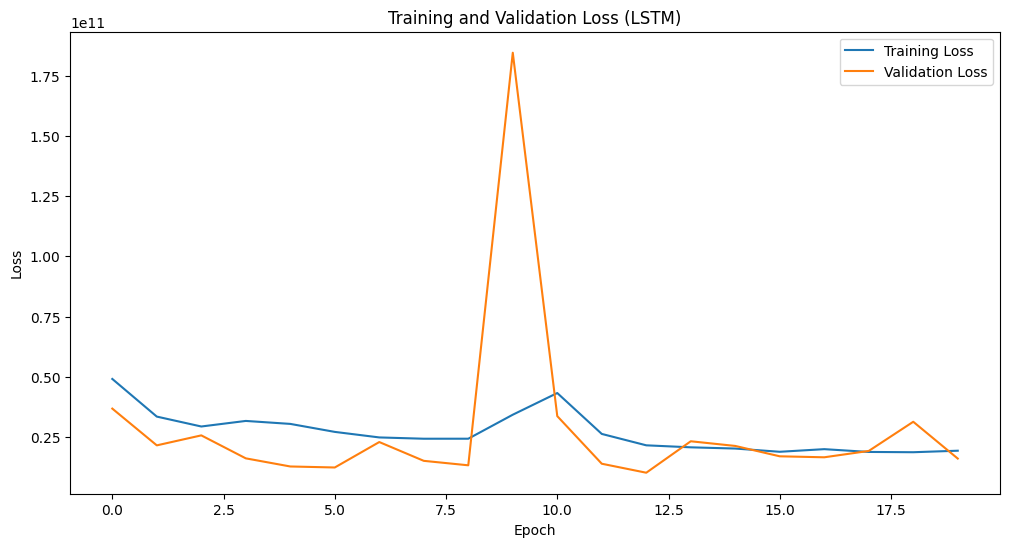

In [33]:
# Train the model
history_lstm = model_lstm.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

4845/4845 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step


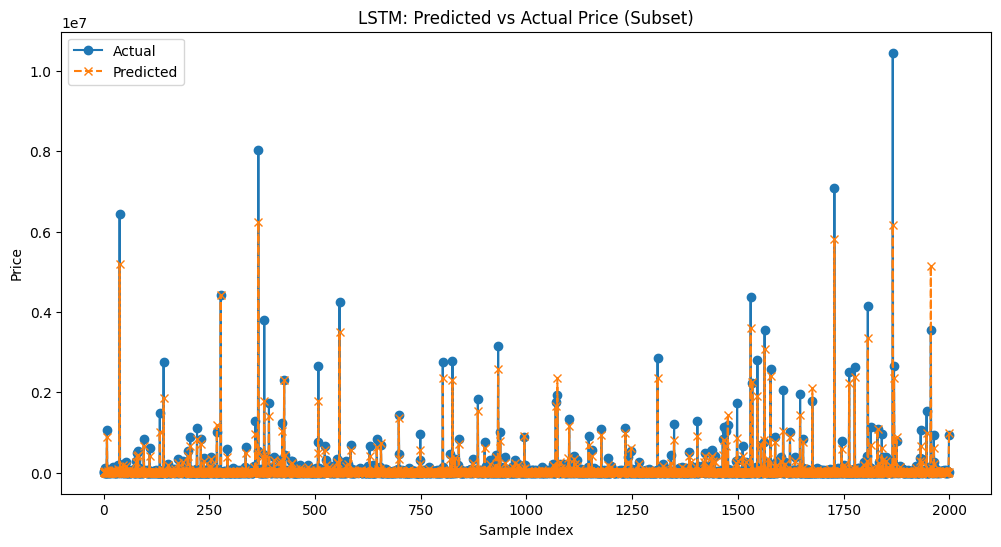

In [35]:
# Make predictions
y_pred_lstm = model_lstm.predict(X_test_scaled)

# Plot actual vs predicted for a subset
subset_indices = np.random.choice(len(y_test), size=2000, replace=False)
subset_actual = y_test[subset_indices]
subset_predicted = y_pred_lstm[subset_indices]

plt.figure(figsize=(12, 6))
plt.plot(subset_actual, label='Actual', linestyle='-', marker='o')
plt.plot(subset_predicted, label='Predicted', linestyle='--', marker='x')
plt.title('LSTM: Predicted vs Actual Price (Subset)')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

In [57]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Flatten, Dropout

# Define the input layer
input_layer = Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))

# CNN layers
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = Dropout(0.2)(cnn)

# LSTM layers
lstm = LSTM(128, activation='relu', return_sequences=True)(cnn)
lstm = LSTM(64, activation='relu')(lstm)
lstm = Dropout(0.2)(lstm)

# Dense layers
dense = Dense(128, activation='relu')(lstm)
dense = Dropout(0.2)(dense)
output_layer = Dense(1)(dense)

# Build the model
model_cnn_lstm = Model(inputs=input_layer, outputs=output_layer)
model_cnn_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary
print(model_cnn_lstm.summary())

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 7, 19)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 7, 64)          │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 7, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 7, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,737 (674.75 KB)

 Trainable params: 172,737 (674.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [58]:
history_cnn_lstm = model_cnn_lstm.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 164s 15ms/step - loss: 94059397120.0000 - mae: 80593.7656 - val_loss: 17732739072.0000 - val_mae: 44638.9453
Epoch 2/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 159s 15ms/step - loss: 34709049344.0000 - mae: 53183.4648 - val_loss: 13253507072.0000 - val_mae: 36605.8945
Epoch 3/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 159s 15ms/step - loss: 32158908416.0000 - mae: 48873.7773 - val_loss: 39442149376.0000 - val_mae: 54852.8477
Epoch 4/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 162s 15ms/step - loss: 30141970432.0000 - mae: 46427.9336 - val_loss: 35109650432.0000 - val_mae: 54208.0430
Epoch 5/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 160s 15ms/step - loss: 33966850048.0000 - mae: 49162.9609 - val_loss: 28345739264.0000 - val_mae: 55831.9570
Epoch 6/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 161s 15ms/step - loss: 27419156480.0000 - mae: 45931.2148 - val_loss: 29105182720.0000 - val_mae: 54228.9766
Epoch 7/20
10819/10819 ━━━━━━━━━━━━━━━━━━━━ 160s 15ms/step - loss: 25534865408.000

4845/4845 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step


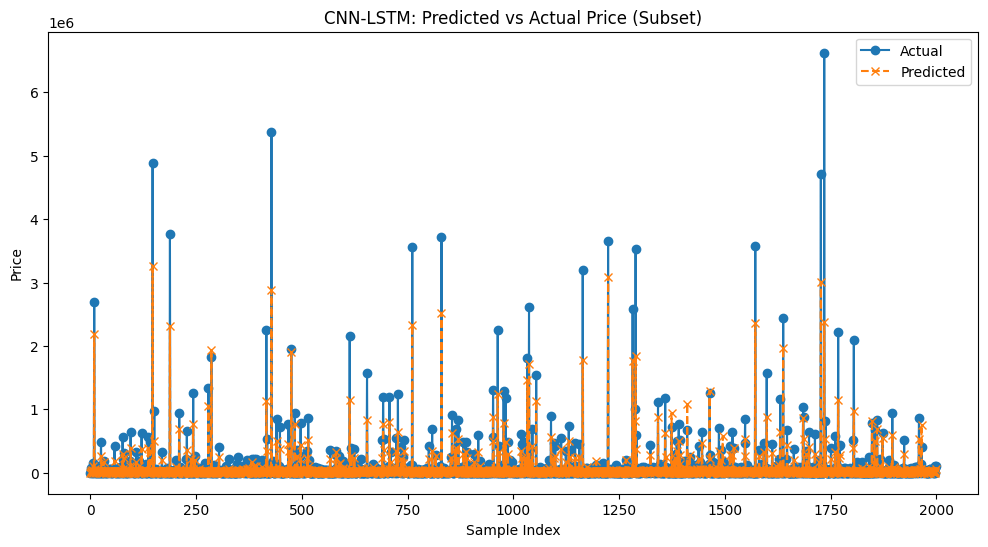

In [59]:
# Make predictions
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_scaled)

# Plot actual vs predicted for a subset
subset_indices = np.random.choice(len(y_test), size=2000, replace=False)
subset_actual = y_test[subset_indices]
subset_predicted = y_pred_cnn_lstm[subset_indices]

plt.figure(figsize=(12, 6))
plt.plot(subset_actual, label='Actual', linestyle='-', marker='o')
plt.plot(subset_predicted, label='Predicted', linestyle='--', marker='x')
plt.title('CNN-LSTM: Predicted vs Actual Price (Subset)')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()

In [45]:
# Extract last prices from sequences
last_prices = X_test_scaled[:, -1, 15]  # Ensure price_index is correct

# Check for price decreases
price_differences = y_test - last_prices
num_price_increases = np.sum(price_differences > 0)
num_price_decreases = np.sum(price_differences < 0)
num_price_same = np.sum(price_differences == 0)

print(f"Number of Price Increases: {num_price_increases}")
print(f"Number of Price Decreases: {num_price_decreases}")
print(f"Number of Prices Remaining the Same: {num_price_same}")

Number of Price Increases: 155021
Number of Price Decreases: 0
Number of Prices Remaining the Same: 0


In [41]:
# Verify feature order in X_test_scaled
feature_columns = [
    'rating', 'skill_moves', 'weak_foot', 'pace_m', 'shooting_m',
    'passing_m', 'dribbling_m', 'defending_m', 'physical_m', 'height',
    'total_ingame_stats', 'nation', 'league', 'club', 'intl_rep', 'price', 
    'days_since_start', 'days_until_end', 'days_since_release'
]

# Find the index of 'price'
price_index = feature_columns.index('price')
print(f"Index of 'price' in feature columns: {price_index}")

# Get the last price in each sequence (from X_test_scaled)
last_prices = X_test_scaled[:, -1, price_index]  # Use the confirmed index for 'price'

# Convert actual and predicted prices to binary labels
actual_prices = y_test
predicted_prices = y_pred_cnn_lstm.flatten()

# Create binary labels
actual_labels = (actual_prices > last_prices).astype(int)
predicted_labels = (predicted_prices > last_prices).astype(int)

# Calculate classification accuracy
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Classification Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(actual_labels, predicted_labels))


Index of 'price' in feature columns: 15
Classification Accuracy: 0.9617

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.96      0.98    155021

    accuracy                           0.96    155021
   macro avg       0.50      0.48      0.49    155021
weighted avg       1.00      0.96      0.98    155021



/Users/vinayaksankaranarayanan/Desktop/FUT_Project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vinayaksankaranarayanan/Desktop/FUT_Project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vinayaksankaranarayanan/Desktop/FUT_Project/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [40]:
# Check distribution of actual labels
import numpy as np
unique, counts = np.unique(actual_labels, return_counts=True)
label_distribution = dict(zip(unique, counts))
print("Distribution of Actual Labels:", label_distribution)

Distribution of Actual Labels: {1: 155021}
